In [1]:
import tensorflow as tf

In [2]:
import tensorflow_hub as hub
import tensorflow_datasets as tfds

In [3]:
from tensorflow.keras import layers

In [4]:
import matplotlib.pyplot as plt

导入模型

In [5]:
classifier_url = TODO!!!#"改为mobilenet_v2文件夹的路径"#"https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
image_res = 224

model = tf.keras.Sequential([
    hub.KerasLayer(classifier_url,input_shape=(image_res,image_res,3))
])

In [6]:
import numpy as np
import PIL.Image as Image

In [7]:
grace_hopper = tf.keras.utils.get_file("image.jpg","https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg")

In [8]:
grace_hopper = Image.open(grace_hopper).resize([image_res,image_res])

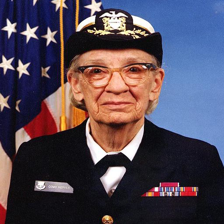

In [9]:
grace_hopper

In [10]:
grace_hopper = np.array(grace_hopper)/255.0

In [11]:
grace_hopper.shape

(224, 224, 3)

In [12]:
result = model.predict(grace_hopper[np.newaxis,...])

In [13]:
result.shape

(1, 1001)

In [14]:
predict_class = np.argmax(result,axis = 1)

In [15]:
predict_class

array([653], dtype=int64)

In [16]:
#这个653对应哪一类呢？
label_path = tf.keras.utils.get_file("ImageNetLabel.txt","https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt")

In [17]:
image_labels = np.array(open(label_path).read().splitlines())

In [18]:
image_labels[653]

'military uniform'

MobileNet on CATS&DOGS

In [19]:

import tensorflow_datasets as tfds
#splits = tfds.Split.
#ALL.subsplit(weight=(80,20))
#splits = tfds.Split.TRAIN.subsplit(weighted=(80,20))
splits,info = tfds.load('cats_vs_dogs',with_info=True,as_supervised=True,split=[ 'train[:80%]', 'train[20%:]'])

In [20]:
(train_examples,validation_examples) = splits

In [21]:
num_examples = info.splits['train'].num_examples

In [22]:
num_classes = info.features['label'].num_classes

In [23]:
for i,example_image in enumerate(train_examples.take(3)):
    print(i+1,example_image[0].shape)

1 (262, 350, 3)
2 (409, 336, 3)
3 (493, 500, 3)


In [24]:
def format_image(image,label):
    image = tf.image.resize(image,(image_res,image_res))/255.0
    return image,label

In [25]:
BATCH_SIZE = 32
train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [26]:
image_batch,label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

In [27]:
result_batch = model.predict(image_batch)

In [28]:
predict_class_names = image_labels[np.argmax(result_batch,axis = 1)]

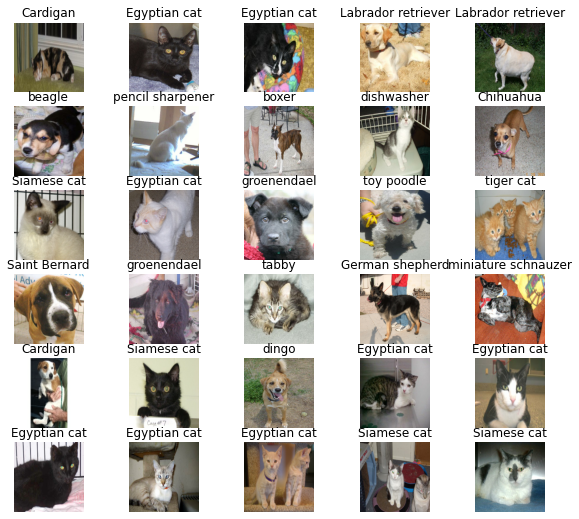

In [29]:
plt.figure(figsize=(10,9))
for x in range(30):
    plt.subplot(6,5,x+1)
    plt.imshow(image_batch[x])
    plt.title(predict_class_names[x])
    plt.axis('off')


新加一层

In [30]:
classifier_url2 = TODO##"改为mobilenetv2_layer文件夹的路径""#"https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
image_res = 224

feature_extractor = tf.keras.Sequential([
    hub.KerasLayer(classifier_url2,input_shape=(image_res,image_res,3))
    
])

In [31]:
feature_extractor.predict(image_batch).shape

(32, 1280)

In [32]:
feature_extractor.trainable = False

In [33]:
model = tf.keras.Sequential([
    feature_extractor,
    layers.Dense(2,activation='softmax')
])

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [35]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
EPOCHS = 6
history = model.fit(train_batches,epochs=EPOCHS,validation_data=validation_batches)

Epoch 1/6
 10/582 [..............................] - ETA: 2:52 - loss: 1.0026 - accuracy: 0.3910

KeyboardInterrupt: 

In [38]:
import time
time1 = time.time()
h5_save_path = './a{}x.h5'.format(int(time1))
print(h5_save_path)
model.save(h5_save_path)
#可能会报错 但已经存成功了

./a1611666744x.h5


ValueError: Unable to create dataset (name already exists)

In [44]:
reloaded = tf.keras.models.load_model(h5_save_path,
                                      custom_objects={'KerasLayer':hub.KerasLayer})

ValueError: Cannot assign to variable Variable:0 due to variable shape (32,) and value shape (3, 3, 3, 32) are incompatible